# 1- Import the data from kaggle

In [1]:
# !pip install -q kaggle
!pip install -q transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 185.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 86.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gc

In [2]:
%%bash

mkdir ~/.kaggle data

mv /content/kaggle.json ~/.kaggle/kaggle.json

kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

unzip -q imdb-dataset-of-50k-movie-reviews.zip -d data

rm imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other



100%|██████████| 25.7M/25.7M [00:01<00:00, 20.1MB/s]


# 2- Data Exploration

In [3]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns

In [4]:
data = load_dataset("csv",  data_files={'train': 'data/IMDB Dataset.csv'})
data

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 50000
    })
})

In [7]:
data.set_format(type='pandas', columns=['review', 'sentiment'])
df = data['train'][:]
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
# How many observations do we have in the dataset?
len(df)

50000

In [9]:
# Is the data balanced?
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


<Axes: xlabel='sentiment', ylabel='count'>

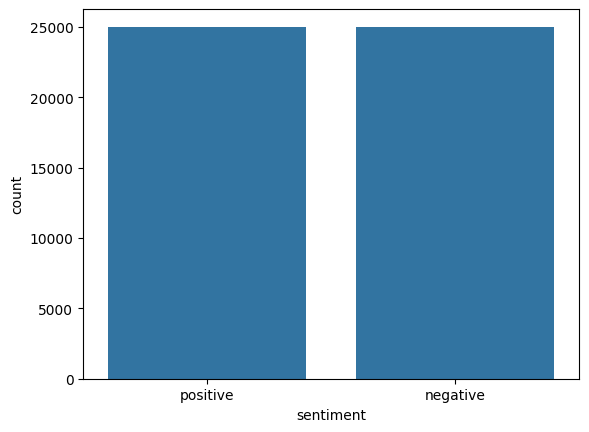

In [10]:
sns.countplot(x='sentiment', data=df)

In [11]:
df['review'][50]

'Return to the 36th Chamber is one of those classic Kung-Fu movies which Shaw produces back in the 70s and 80s, whose genre is equivalent to the spaghetti westerns of Hollywood, and the protagonist Gordon Liu, the counterpart to the western\'s Clint Eastwood. Digitally remastered and a new print made for the Fantastic Film Fest, this is "Presented in Shaw Scope", just like the good old days.<br /><br />This film is a simple story of good versus evil, told in 3 acts, which more or less sums up the narrative of martial arts films in that era.<br /><br />Act One sets up the premise. Workers in a dye-mill of a small village are unhappy with their lot, having their wages cut by 20% by incoming manchu gangsters. They can\'t do much about their exploitation because none of them are martial arts skilled to take on the gangsters, and their boss. At first they had a minor success in getting Liu to impersonate a highly skilled Shaolin monk (one of the best comedy sequences), but their rouse got e

In [12]:
data.reset_format()
data

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 50000
    })
})

# 3- Split the data

In [13]:
from datasets import DatasetDict

In [14]:
train_test = data['train'].shuffle().train_test_split(test_size=0.2)
train_test

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 10000
    })
})

In [15]:
test_val = train_test['test'].shuffle().train_test_split(test_size=0.5)
test_val

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 5000
    })
})

In [16]:
dataset = DatasetDict({
    'train': train_test['train'],
    'val': test_val['test'],
    'test': test_val['train']
})

dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 40000
    })
    val: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 5000
    })
})

# 4- Cleaning Function


In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

import re

In [19]:
def clean_fn(examples):

    text = examples['review']
    label = examples['sentiment']

    out_text = text.lower() # Text Normalization

    out_text = re.sub('<br />', ' ' , out_text)
    out_text = re.sub('https?://\S+|www\.\S+', ' ' , out_text)
    out_text = re.sub('[^a-zA-Z]', ' ' , out_text)

    out_text = out_text.split() # Create a list of words from the text

    # Extract the root of each word and include it if it isn't a stopword
    out_text = [ps.stem(word) for word in out_text if not word in set(stopwords.words('english'))]

    out_text = [word for word in out_text if len(word) > 2] # Remove the words that are less than 2 characters

    examples['review'] = ' '.join(out_text) # Return the text as a string
    examples['sentiment'] = 1 if label == 'positive' else 0

    return examples

In [20]:
dataset['train']['review'][5]

"This movie was really funny even though it wasn't meant to be! The acting was stupid and so were the voices. Pretty much all it was was some guy walking around a corn maze for an hour and a half. They threw in this stupid super natural thing that made it even dumber. It wasn't even like a normal movie, this weird creepy music was playing almost the whole way through the movie. What is it with corn maze horror films? Children of the corn was really scary I thought and I thought this would be something like it, but really it was just stupid. The main character guy just walked around aimlessly yelling for these two little girls. And then at the end he like kills someone or something. It's worth seeing if you're with your friends because it's really funny how bad it is, but if you're looking for a horror movie then don't waste your time"

In [21]:
clean_fn(dataset['train'][5])

{'review': 'movi realli funni even though meant act stupid voic pretti much guy walk around corn maze hour half threw stupid super natur thing made even dumber even like normal movi weird creepi music play almost whole way movi corn maze horror film children corn realli scari thought thought would someth like realli stupid main charact guy walk around aimlessli yell two littl girl end like kill someon someth worth see friend realli funni bad look horror movi wast time',
 'sentiment': 0}

In [22]:
cleaned_data = dataset.map(clean_fn)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [23]:
cleaned_data = cleaned_data.rename_columns({'review':'text', 'sentiment': 'label'})
cleaned_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 40000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

# 5- Tokenization

In [24]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # For Dynamic Padding

In [73]:
seq_len = 256

def tokenize(examples):
    return tokenizer(
        examples['text'],
        max_length = seq_len,
        truncation = True,
        padding = 'max_length',
        add_special_tokens = True,
    )

In [27]:
tokenized_data = cleaned_data.map(tokenize, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [28]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 40000
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
})

# 6- Evaluation Function

In [29]:
import evaluate

accuracy = evaluate.load("accuracy")

In [30]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# 7- Train

In [31]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [32]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [33]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
training_args = TrainingArguments(
    output_dir="IMDB_Classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.302000,0.285726,0.883400
2,0.210700,0.279868,0.901200


TrainOutput(global_step=5000, training_loss=0.27579097595214846, metrics={'train_runtime': 3531.0248, 'train_samples_per_second': 22.656, 'train_steps_per_second': 1.416, 'total_flos': 1.05244422144e+16, 'train_loss': 0.27579097595214846, 'epoch': 2.0})

# 8- Inference and Evaluation

In [131]:
from transformers import AutoModelForSequenceClassification
import torch

In [43]:
trainer.evaluate(tokenized_data['val'])

{'eval_loss': 0.28212103247642517,
 'eval_accuracy': 0.9,
 'eval_runtime': 67.6583,
 'eval_samples_per_second': 73.901,
 'eval_steps_per_second': 4.626,
 'epoch': 2.0}

In [118]:
tuned_model = AutoModelForSequenceClassification.from_pretrained('IMDB_Classifier/checkpoint-5000')

In [96]:
text = '''This was a masterpiece.
Not completely faithful to the books, but enthralling from beginning to end.
Might be my favorite of the three.'''

In [126]:
inputs = tokenizer(text, return_tensors="pt")
inputs

{'input_ids': tensor([[    0,   713,    21,    10, 27107,     4, 50118,  7199,  2198, 15828,
             7,     5,  2799,     6,    53,  3838,  5039,  9391,    31,  1786,
             7,   253,     4, 50118,   448,  5971,    28,   127,  2674,     9,
             5,   130,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [132]:
with torch.no_grad():
    logits = tuned_model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'POSITIVE'